In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    df = dict(npz_file.items())
X = df['overfeat']
y = df['labels']
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(X,y,train_size=4000,test_size=1000,random_state=0,stratify = y)

In [5]:
X_tr_tr,X_tr_valid,y_tr_tr,y_tr_valid = train_test_split(X_tr,y_tr,train_size=3200,test_size=800,random_state=0)

In [32]:
max_depth = np.arange(1,20)
scores = []

for d in max_depth:
    dt = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=0)
    dt.fit(X_tr_tr,y_tr_tr)
    train_accuracy = dt.score(X_tr_tr,y_tr_tr)
    validation_accuracy = dt.score(X_tr_valid, y_tr_valid)
    scores.append({'depth': d, 'train accuracy': train_accuracy,'validation accuracy': validation_accuracy})

In [34]:
import pandas as pd
score = pd.DataFrame(scores)
score.sort_values(by='validation accuracy',ascending=False).head()

,depth,train accuracy,validation accuracy
5,6,0.768750,0.60750
6,7,0.832500,0.60375
11,12,0.992188,0.59625
9,10,0.975000,0.59500
4,5,0.712187,0.59250


Below added preprocessing with PCA, results slighted improved.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pipe = Pipeline([
    ('pca', PCA(n_components=163)),
    ('dt', DecisionTreeClassifier())
])

In [37]:
max_depth = np.arange(1,20)
scores=[]

for d in max_depth:
    pipe.set_params(dt__max_depth=d, dt__criterion='gini') 
    pipe.fit(X_tr_tr,y_tr_tr)
    train_accuracy = pipe.score(X_tr_tr,y_tr_tr)
    validation_accuracy = pipe.score(X_tr_valid, y_tr_valid)
    scores.append({'depth': d, 'train accuracy': train_accuracy,'validation accuracy': validation_accuracy})

In [60]:
score1 = pd.DataFrame(scores)
score.sort_values(by='validation accuracy',ascending=False).head()

,depth,train accuracy,validation accuracy
4,5,0.708750,0.64500
5,6,0.767500,0.64375
3,4,0.674375,0.62750
6,7,0.817813,0.62375
7,8,0.878125,0.62250


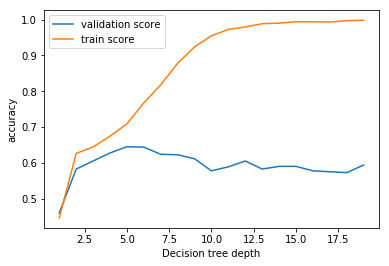

In [62]:
%matplotlib inline
from matplotlib import pyplot as plt
a = score1.depth.values
b = score1['validation accuracy'].values
c = score1['train accuracy'].values
plt.plot(a,b, label='validation score')
plt.plot(a,c, label='train score')
plt.xlabel('Decision tree depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Depth 5 is where validation score reaches its highest. Before depth 5, both train and test accuracy increases with the depth, which means as the model becomes complex, model is less underfitting (high bias), after depth 5, train accuracy continues to increase and validation accuracy stopped to increase, which means the model is overfitting after depth 5, high variance.

In [67]:
d = score1.sort_values(by='validation accuracy',ascending=False).iloc[0]
print('Top accuracy on validation set:', d[2], 'with depth:', d[0])

Top accuracy on validation set: 0.645 with depth: 5.0


In [77]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = [1,50,100,150,200,250,300]
scores = []

for n in n_estimators:
    rt = RandomForestClassifier(n_estimators=n,max_depth=5,random_state=0)
    rt.fit(X_tr_tr,y_tr_tr)
    train_accuracy = rt.score(X_tr_tr,y_tr_tr)
    validation_accuracy = rt.score(X_tr_valid, y_tr_valid)
    scores.append({'n_estimators': n, 'train accuracy': train_accuracy,'validation accuracy': validation_accuracy})

In [78]:
rf_score = pd.DataFrame(scores)
rf_score.sort_values(by='validation accuracy',ascending=False).head()

,n_estimators,train accuracy,validation accuracy
4,200,0.869687,0.7925
5,250,0.869375,0.7900
6,300,0.872812,0.7900
2,100,0.868750,0.7875
3,150,0.867500,0.7800


# Use tuned model to fit test data

In [82]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)
dt.fit(X_tr,y_tr)
dt_accuracy = dt.score(X_te,y_te)
print('Decision Tree accuracy (test set):', dt_accuracy)

Decision Tree accuracy (test set): 0.658


In [81]:
rt = RandomForestClassifier(n_estimators=200,max_depth=5,random_state=0)
rf.fit(X_tr,y_tr)
rf_accuracy = rf.score(X_te,y_te)
print('Random forest accuracy (test set):', rf_accuracy)

Random forest accuracy (test set): 0.772
